In [126]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from pm4py.algo.evaluation.earth_mover_distance import algorithm as earth_mover_distance

In [127]:
file_name = "syn_4"
attribute_key = "property_lt_20"

In [128]:
case_attribute_key = f'case:{attribute_key}'
case_id_key = "case:concept:name"

# df = pm4py.read_xes(f'../logs/{file_name}.xes')
df = pd.read_csv(f'../logs/{file_name}.{attribute_key}.chared.csv')
df["time:timestamp"] = pd.to_datetime(df['time:timestamp'])
df["case:concept:name"] = df['case:concept:name'].astype(str)
df["concept:name"] = df['concept:name'].astype(str)

print(f"log size: {df.groupby(df[case_id_key]).ngroups}")
print("removing empty rows...")

df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

print(f"log size: {df.groupby(df[case_id_key]).ngroups}")
print("removing traces with > 1000 events...")

df = df[df[case_id_key].groupby(df[case_id_key]).transform('size') < 1500].drop(columns=["level_0","Unnamed: 0", "index"]).reset_index() # filter traces with > 1500 events

print(f"log size: {df.groupby(df[case_id_key]).ngroups}")

display(df.head())

log size: 557
removing empty rows...
log size: 557
removing traces with > 1000 events...
log size: 556


,index,case:concept:name,concept:name,time:timestamp,lifecycle:transition,case:Age:1
0,0,1,124,2005-01-02 23:00:00+00:00,complete,39.0
1,1,1,34,2005-01-02 23:00:00+00:00,complete,39.0
2,2,1,13,2005-01-02 23:00:00+00:00,complete,39.0
3,3,1,78,2005-01-05 23:00:00+00:00,complete,39.0
4,4,1,5,2005-01-05 23:00:00+00:00,complete,39.0


In [129]:
attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)

In [1]:
df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

emscs = []

t = time.time()

for pivot in tqdm(sorted_attribute_values[1:]):

    # find affected cases
    df_affected_light_idx = df_gte_light[df_gte_light[case_attribute_key] < pivot].index

    # remove affected cases from gte group
    df_gte_light.drop(df_affected_light_idx, inplace=True)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light_idx ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    stochastic_language_lt = { k: v / language_lt_size for k, v in language_lt.items() }
    stochastic_language_gte = { k: v / language_gte_size for k, v in language_gte.items() }

    # emsc = earth_mover_distance.apply(stochastic_language_lt, stochastic_language_gte)
    emsc = pm4py.compute_emd(stochastic_language_lt, stochastic_language_gte)

    # collect data to plot graph
    emscs.append(emsc)

t = time.time() - t

time.sleep(1)

print(f"time elapsed: {t}")

NameError: name 'grouped' is not defined

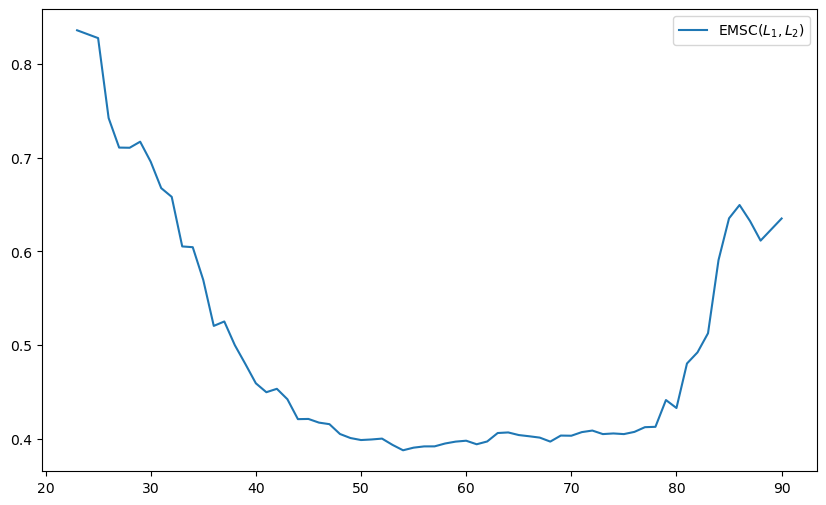

In [ ]:
plt.figure(figsize=(10,6))

# plot mmlngld
plt.plot(sorted_attribute_values[1:], emscs, label=r"EMSC$(L_1,L_2)$")
plt.legend()
plt.savefig(f"out.emsc.{file_name}.{attribute_key}.png", bbox_inches="tight")

In [ ]:
pd.DataFrame({"emsc": emscs}).to_csv(f"out.emsc.{file_name}.{attribute_key}.csv", index=False, header=False)